In [ ]:
#PLEASE CHANGE RUNTIME TO GPU IN COLLAB
#THE BELOW WORK IS A RESULT OF COLLABORATION AND IDEA EXCHANGE BETWEEN SAI, SAYANTAN AND MYSELF. THEY DESERVE THIS RANK AS MUCH AS I.
##YOU NEED TO CHANGE ADDRESS TO SAVE IN 4 PLACES INSIDE THIS CODE, PLEASE FOLLOW COMMENTS
!pip install catboost
!pip install --upgrade pandas
!pip install --upgrade numpy
!pip install -U scikit-learn==0.21
!pip install scikit-optimize

In [1]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
# from reg_resampler import resampler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_validate,cross_val_score
import seaborn as sns
from sklearn.metrics import mean_squared_error ,accuracy_score
from google.colab import files
from sklearn.model_selection import KFold, train_test_split
import csv
import numpy as np
import os
import featuretools as ft
import featuretools.variable_types as vtypes
from catboost import CatBoostRegressor
import warnings
from math import sqrt
from sklearn.ensemble import ExtraTreesRegressor
from google.colab import drive
import sklearn as sk
from scipy import stats
import re
from collections import Counter
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
drive.mount("/GD")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Drive already mounted at /GD; to attempt to forcibly remount, call drive.mount("/GD", force_remount=True).


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    #objecttype=['object']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #if col_type in objecttype:
            #df[col]=df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
#PREPROCESSING MODULE
#######change address here for verification#############
df_train = pd.read_csv("/GD/My Drive/cancer/Train.csv")
df_test = pd.read_csv("/GD/My Drive/cancer/Test.csv")
########################################################
key=df_train.drop(['tumor_size'],axis=1).columns.tolist()
df_test['key']=df_test[key].apply(lambda x: '_'.join(x.astype('str')), axis = 1)
df_train['key']=df_train[key].apply(lambda x: '_'.join(x.astype('str')), axis = 1)
df=pd.DataFrame(df_train.groupby(['key'],as_index=False)['tumor_size'].mean())
df=df.reset_index()
encode = dict(zip(df.key, df.tumor_size))
df_test['tumor_size']=df_test.key.map(encode)
df_test2=df_test[np.isnan(df_test.tumor_size)].drop(['tumor_size'],axis=1)
df_train2=df_train.drop(['tumor_size'],axis=1).drop_duplicates()
encode3 = dict(zip(df_train.key, df_train.tumor_size))
df_train2['tumor_size']=df_train2.key.map(encode3)
df_train2=df_train2[df_train2.tumor_size>0]
df_test2['is_what']='test'
df_train2['is_what']='train'
Y=df_train2['tumor_size']
fulldf=df_train2.drop(['tumor_size'],axis=1).append(df_test2)
reduce_mem_usage(fulldf)


In [18]:
#################################FEATURE ENGINEERING#######################################################################
df2=fulldf
es = ft.EntitySet(id = 'power')
categories=['key','is_what']
variable_types=dict.fromkeys(categories, vtypes.Categorical)

es.entity_from_dataframe(entity_id = 'data', dataframe = df2, 
                         make_index = True, index = 'index',variable_types=variable_types)
feature_matrix, feature_list = ft.dfs(entityset = es, target_entity = 'data',
                                      trans_primitives = ['percentile','divide','multiply'],max_depth=2
                                      )
main2=feature_matrix
main2.replace([np.inf, -np.inf], np.nan,inplace=True)
TEST=main2[main2['is_what']=='test'].drop(['is_what'],axis=1)
TRAIN=main2[main2['is_what']=='train'].drop(['is_what'],axis=1)
#NOW COMBINING SAYANTAN AND SAI'S FEATURES
#sayantan's features
TRAIN['total_estimated_samples'] =   TRAIN['err_malign'] / TRAIN['std_dev_malign']  
TEST['total_estimated_samples'] =   TEST['err_malign'] / TEST['std_dev_malign'] 
TRAIN['tumor_area'] = TRAIN['exposed_area'] - TRAIN['damage_size']
TEST['tumor_area'] = TEST['exposed_area'] - TEST['damage_size']
TRAIN['tumor_mass'] = TRAIN['tumor_area'] * TRAIN['mass_npea'] / TRAIN['size_npear']
TEST['tumor_mass'] = TEST['tumor_area'] * TEST['mass_npea'] / TEST['size_npear']
TRAIN['feat_1'] = TRAIN['malign_penalty'] * TRAIN['mass_npea']
TEST['feat_1'] = TEST['malign_penalty'] * TEST['mass_npea']

#sai's features
TRAIN["exposed_area_by_size_npear"] = (TRAIN["exposed_area"]/TRAIN["size_npear"])*TRAIN["malign_ratio"]
TEST["exposed_area_by_size_npear"] = (TEST["exposed_area"]/TEST["size_npear"])*TEST["malign_ratio"]


In [19]:
###CHANGE THE ADDRESS BELOW BEFORE RUNNING THIS CODE. REPLACE ADDRESS 1 WITH UR LOCATION########
#feature selection, the biggest headache and the most time wasted doing this
CBOTHER=['total_estimated_samples', 'err_malign', 'damage_size', 'damage_ratio',
       'tumor_mass', 'exposed_area_by_size_npear', 'malign_penalty', 'feat_1',
       'std_dev_malign', 'tumor_area']
MAINCB=['size_npear / damage_size', 'PERCENTILE(damage_size) / damage_size',
       'exposed_area_by_size_npear',
       'PERCENTILE(mass_npea) / PERCENTILE(exposed_area)',
       'malign_penalty / damage_size', 'PERCENTILE(exposed_area) / size_npear',
       'damage_ratio * err_malign',
       'malign_penalty / err_malign * malign_ratio / damage_size',
       'damage_size / size_npear',
       'malign_penalty / damage_size * malign_ratio / damage_size',
       'malign_ratio / exposed_area * PERCENTILE(err_malign)',
       'malign_penalty / PERCENTILE(malign_penalty)',
       'damage_ratio / exposed_area * damage_size / malign_ratio',
       'PERCENTILE(malign_penalty) / damage_size',
       'malign_penalty / mass_npea * PERCENTILE(damage_ratio)',
       'err_malign / mass_npea * PERCENTILE(std_dev_malign)',
       'err_malign / damage_size * PERCENTILE(damage_ratio)',
       'damage_ratio * PERCENTILE(std_dev_malign)',
       'PERCENTILE(mass_npea) / PERCENTILE(malign_penalty)',
       'malign_ratio / err_malign * PERCENTILE(malign_penalty)',
       'PERCENTILE(std_dev_malign) / mass_npea',
       'malign_penalty / std_dev_malign * malign_ratio / exposed_area',
       'damage_size / mass_npea * std_dev_malign / mass_npea',
       'PERCENTILE(damage_ratio) * PERCENTILE(err_malign)',
       'PERCENTILE(err_malign) / PERCENTILE(exposed_area)',
       'damage_ratio * PERCENTILE(err_malign)',
       'damage_ratio / damage_size * malign_penalty / damage_size',
       'PERCENTILE(err_malign) / std_dev_malign',
       'damage_ratio / std_dev_malign * damage_size',
       'PERCENTILE(malign_penalty) / malign_ratio',
       'PERCENTILE(std_dev_malign) / err_malign',
       'damage_ratio * PERCENTILE(damage_size)',
       'err_malign / std_dev_malign * malign_ratio / mass_npea',
       'PERCENTILE(malign_penalty) / err_malign',
       'malign_penalty / size_npear * PERCENTILE(damage_ratio)',
       'err_malign / size_npear * malign_ratio / damage_ratio',
       'err_malign / damage_size * malign_penalty / damage_size']
imp_columns=CBOTHER+MAINCB
IMP_COLUMNS2=list(set(imp_columns))
TRAIN_FINAL=TRAIN[IMP_COLUMNS2]
TEST_FINAL=TEST[IMP_COLUMNS2]
reduce_mem_usage(TRAIN_FINAL)
reduce_mem_usage(TEST_FINAL)
#BELOW PART FREES UP RAM AND MAKES IT SUSTAINABLE TO RUN THE UPCOMING MODELS
#####change address here#############
#DONT CHANGE THE SAVING FILE NAME JUST CHANGE THE LOCATION AS PER YOUR OWN DRIVE
TRAIN_FINAL.to_csv("/GD/My Drive/cancer/TRAIN_FINAL.csv",index=False)
TEST_FINAL.to_csv("/GD/My Drive/cancer/TEST_FINAL.csv",index=False)
Y.to_csv("/GD/My Drive/cancer/Y.csv",index=False)
########################################

#CB COMPLETELY TUNED AND PROVIDED BY SAI.
cb1=CatBoostRegressor(random_state=25,n_estimators=4000,task_type="GPU",devices="0:1",boosting_type="Plain",#.6
                              verbose=0,max_depth=13,learning_rate=0.09)
cb2=CatBoostRegressor(random_state=18,n_estimators=3000,task_type="GPU",devices="0:1",boosting_type="Plain",#.4
                              verbose=0,max_depth=11,learning_rate=0.095)


###CHANGE ADDRESS HERE GIVE SAME LOCATION AS ABOVE IN PLACE OF ADDRESS 1###########
###THIS PART NEEDED TO FREE UP RUNTIME MEMORY#################
TRAIN_FINAL=pd.read_csv("/GD/My Drive/cancer/TRAIN_FINAL.csv")
TEST_FINAL=pd.read_csv("/GD/My Drive/cancer/TEST_FINAL.csv")
Y=pd.read_csv("/GD/My Drive/cancer/Y.csv")
Y=Y['tumor_size']
##################################
reduce_mem_usage(TRAIN_FINAL)
reduce_mem_usage(TEST_FINAL)
TRAIN=[]
TEST=[]

Mem. usage decreased to  0.94 Mb (66.5% reduction)
Mem. usage decreased to  3.77 Mb (66.5% reduction)
Mem. usage decreased to  0.88 Mb (72.3% reduction)
Mem. usage decreased to  3.50 Mb (72.3% reduction)


In [7]:
#Runtime 55mins
#FOR CB1 warning: takes huge time! if you are happy with a little lesser scores, reduce the estimators!
#suggest to open another google collab window and run two folds simultaneously. You can combine them by ratios even manually later from excel
i=0
l=[]
setused=TRAIN_FINAL[MAINCB]
targ=Y
test=TEST_FINAL
scores=[]
splits=15
cnf_matrix=[]
oof_preds = np.zeros((len(test)))
kfold, scores = KFold(n_splits=splits,random_state=True), list()
for train2, test2 in kfold.split(setused,targ):
    x_train, x_test = setused.values[train2], setused.values[test2]
    y_train, y_test = targ.values[train2], targ.values[test2]
    model = cb1
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    #############################
    feature_importances = pd.DataFrame(model.feature_importances_,
                                       index = setused.columns,
                                        columns=['importance'])
    sum=feature_importances.values
    l.append(sum)
    #############################
    score = np.sqrt(mean_squared_error(y_test, preds))
    scores.append(score)
    print(score)
    oof_preds += model.predict(test[setused.columns.tolist()].values)
oof_preds = oof_preds/splits

print("Average: ", np.sum(scores)/len(scores))
#3.395748867305454

3.395748867305454
3.635446459349284
3.4622486979800278
3.4417551028858937
3.5530359422377304
3.5215868209170895
3.5882127096584573
3.7874274457968276
3.8404595386530884
3.8220729898474155
3.5969254205796566
3.5674265119946464
3.7747989575715395
3.303760235792461
3.719877148303528
Average:  3.6007188565915396


In [21]:
#for CB2. RUNTIME AT 15MINS
#suggest to open another google collab window and run two folds simultaneously. You can combine them by ratios even manually later from excel
i=0
l=[]
setused=TRAIN_FINAL[CBOTHER]
targ=Y
test=TEST_FINAL
scores=[]
splits=16
cnf_matrix=[]
oof_preds2 = np.zeros((len(test)))
kfold, scores = KFold(n_splits=splits,random_state=True), list()
for train2, test2 in kfold.split(setused,targ):
    x_train, x_test = setused.values[train2], setused.values[test2]
    y_train, y_test = targ.values[train2], targ.values[test2]
    model = cb2
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    #############################
    feature_importances = pd.DataFrame(model.feature_importances_,
                                       index = setused.columns,
                                        columns=['importance'])
    sum=feature_importances.values
    l.append(sum)
    #############################
    score = np.sqrt(mean_squared_error(y_test, preds))
    scores.append(score)
    print(score)
    oof_preds2 += model.predict(test[setused.columns.tolist()].values)
oof_preds2 = oof_preds2/splits

print("Average: ", np.sum(scores)/len(scores))
#3.5556950201910067

3.476932683721444
3.7224059807396492
3.63754996192147
3.4974337145071415
3.652316499789447
3.330023153304485
3.8062989399707905
3.7062989204833734
3.9534274268919227
3.7606651881127235
3.9598905510490465
3.5656502780118413
3.8339717963560638
3.778348980347873
3.487104272737782
3.807421071788855
Average:  3.6859837137333695


10

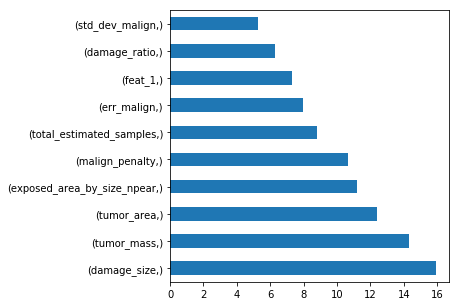

In [26]:
train_set=setused
labels=Y
threshold=0.8
add=0
for item in l:
  add+=item
df_cv=pd.DataFrame(add/len(l),index=train_set.columns,columns=["importance"]).sort_values('importance', ascending=False)
imp_columns=df_cv[df_cv['importance']>threshold].index.tolist()
df_cv=df_cv.reset_index()
feat_imp = pd.Series(df_cv.importance.values, index=df_cv.drop(["importance"], axis=1)).sort_values(axis='index',ascending=False)
X2=setused[imp_columns]
feat_imp.nlargest(29).plot(kind='barh', figsize=(5,5))
len(imp_columns)

In [25]:
##submission module oof
oof=oof_preds*.6+oof_preds2*.4
filen='submission.xlsx'
df_test2['tumor_size']=oof
encode2 = dict(zip(df_test2.key, df_test2.tumor_size))
df1=pd.DataFrame()
df1['tumor_size']=df_test['tumor_size'].fillna(df_test['key'].map(encode2))
df1=df1.clip(lower=0)
df1.fillna(0,inplace=True)
###change download adress here according to ur drive####################
df1['tumor_size'].to_excel('/GD/My Drive/cancer/'+str(filen),index=False)
files.download('/GD/My Drive/cancer/'+str(filen))
#######################################################################

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>